In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from xgboost import XGBRegressor
import multiprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
import joblib

from math import sqrt
import warnings
warnings.filterwarnings('ignore')

# **DATA INGESTION**

In [2]:
df = pd.read_csv('data/gemstone.csv')

In [3]:
print("Dataframe Head :\n\n")
print(df.head())
print("\n\nNull values:\n\n")
print(df.isnull().sum())
print("\n\nDuplicate values:\n\n")
print(df.duplicated().sum())
print("\n\nDataframe info:\n")
print(df.info())

Dataframe Head :


   id  carat        cut color clarity  depth  table     x     y     z  price
0   0   1.52    Premium     F     VS2   62.2   58.0  7.27  7.33  4.55  13619
1   1   2.03  Very Good     J     SI2   62.0   58.0  8.06  8.12  5.05  13387
2   2   0.70      Ideal     G     VS1   61.2   57.0  5.69  5.73  3.50   2772
3   3   0.32      Ideal     G     VS1   61.6   56.0  4.38  4.41  2.71    666
4   4   1.70    Premium     G     VS2   62.6   59.0  7.65  7.61  4.77  14453


Null values:


id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64


Duplicate values:


0


Dataframe info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  objec

#**EXPLORATORY DATA ANALYSIS**

In [4]:
# remove unwanted column
df.drop('id', axis=1, inplace=True)

In [5]:
## Independent and dependent features
X = df.drop(labels=['price'],axis=1)
Y = df[['price']]

In [6]:
# seperate categorical and numerical columns
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

print("Categorical columns:\n")
print(cat_cols)
print("\nNumerical columns:\n")
print(num_cols)

Categorical columns:

Index(['cut', 'color', 'clarity'], dtype='object')

Numerical columns:

Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')


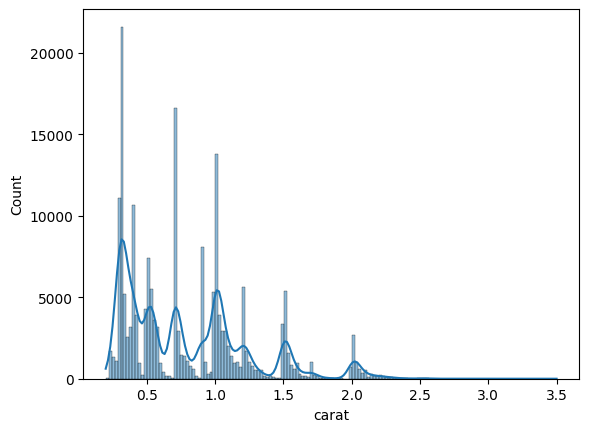

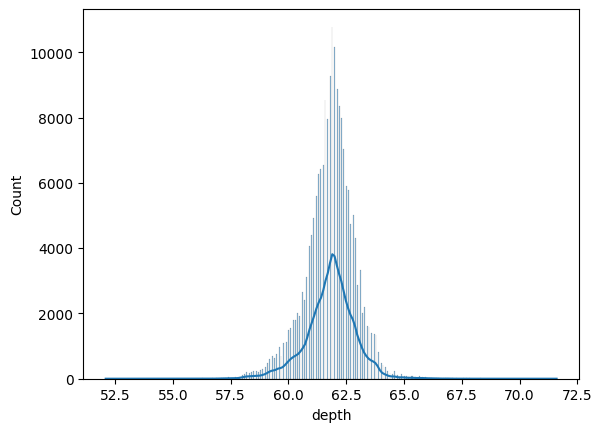

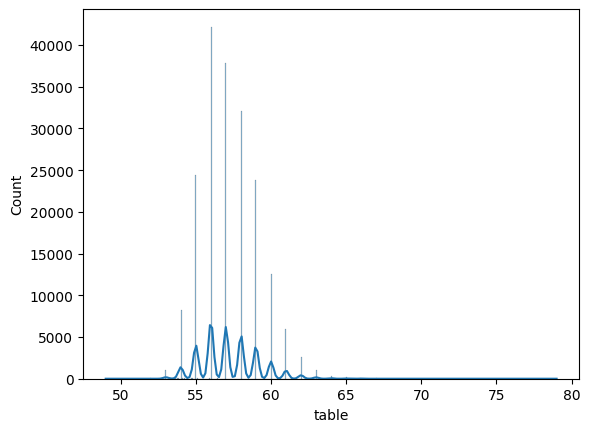

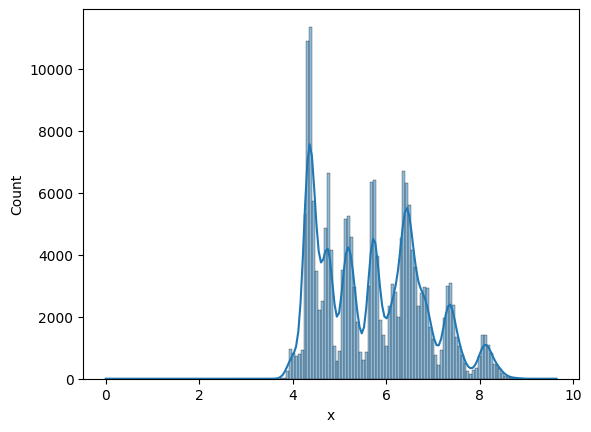

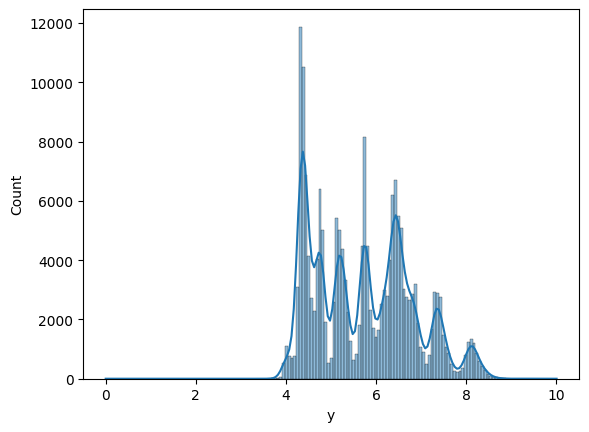

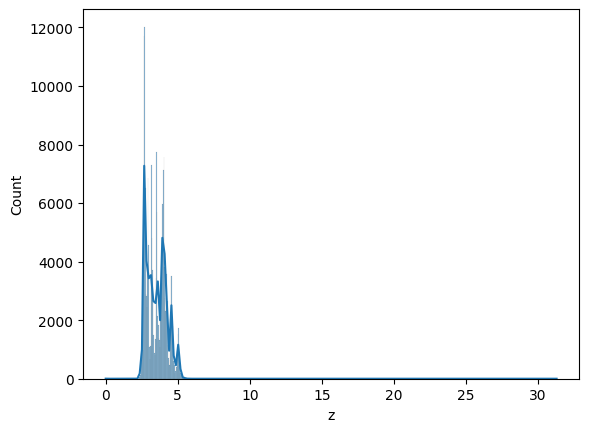

In [7]:
# histplots for every feature in numerical columns
for i in num_cols:
  sns.histplot(data=df, x=i, kde=True)
  plt.show()
  print('\n')

<Axes: >

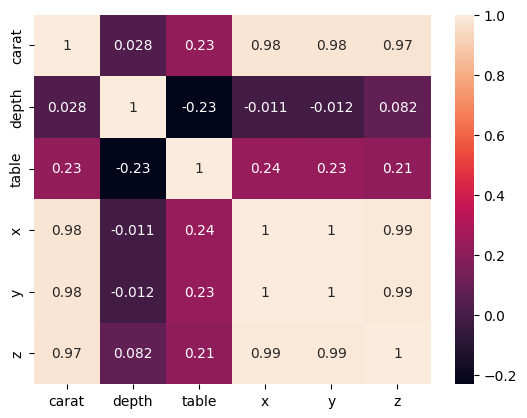

In [8]:
# correlation between features (numerical)
sns.heatmap(df[num_cols].corr(), annot=True)

#**DATA TRANSFORMATION AND FEATURE ENGINEERING**

In [9]:
# pipeline for ordinal encoding, imputing and scaling
# for domain purpose to get an idea of ranking for ordinal encoding -- https://www.americangemsociety.org/ags-diamond-grading-system/

print("CUT : ")
print(df['cut'].unique())
print("\n\nCLARITY :")
print(df['clarity'].unique())
print("\n\nCOLOR :")
print(df['color'].unique())

CUT : 
['Premium' 'Very Good' 'Ideal' 'Good' 'Fair']


CLARITY :
['VS2' 'SI2' 'VS1' 'SI1' 'IF' 'VVS2' 'VVS1' 'I1']


COLOR :
['F' 'J' 'G' 'E' 'D' 'H' 'I']


In [10]:
# cut_map={"Fair":1,"Good":2,"Very Good":3,"Premium":4,"Ideal":5}
# clarity_map = {"I1":1,"SI2":2 ,"SI1":3 ,"VS2":4 , "VS1":5 , "VVS2":6 , "VVS1":7 ,"IF":8}
# color_map = {"D":1 ,"E":2 ,"F":3 , "G":4 ,"H":5 , "I":6, "J":7}

# df['cut']=df['cut'].map(cut_map)
# df['clarity'] = df['clarity'].map(clarity_map)
# df['color'] = df['color'].map(color_map)

# print(df.head())

# Define the custom ranking for each ordinal variable
cut_categories = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_categories = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_categories = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

# Numerical Pipeline
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())

    ]

)

# Categorigal Pipeline
cat_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinalencoder', OrdinalEncoder(categories=[
         cut_categories, color_categories, clarity_categories])),
        ('scaler', StandardScaler())
    ]

)

preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
])

#**MODEL TRAINING AND EVALUATION**

In [11]:
# train, validation, test split
X_train_full,X_test,y_train_full,y_test = train_test_split(X,Y, test_size=0.30, random_state=30)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [12]:
# creating X_train and X_test dataframes using the preprocessed data
X_train=pd.DataFrame(preprocessor.fit_transform(X_train),columns=preprocessor.get_feature_names_out())
X_test=pd.DataFrame(preprocessor.transform(X_test),columns=preprocessor.get_feature_names_out())

print("X_train: \n\n")
print(X_train.head())

X_train: 


   num_pipeline__carat  num_pipeline__depth  num_pipeline__table  \
0             1.963446            -1.036259             1.441984   
1            -0.975576            -2.147763             0.920534   
2            -1.040408            -0.943634            -1.165265   
3             0.450714            -1.128884             0.920534   
4             0.666818             0.538371             0.399084   

   num_pipeline__x  num_pipeline__y  num_pipeline__z  cat_pipeline__cut  \
0         1.804700         1.775685         1.656024          -0.131973   
1        -1.051659        -1.035459        -1.194149          -0.131973   
2        -1.204839        -1.171482        -1.237553           0.875412   
3         0.732439         0.678432         0.585401          -0.131973   
4         0.795513         0.760046         0.802419          -0.131973   

   cat_pipeline__color  cat_pipeline__clarity  
0             0.294368               0.021807  
1            -0.320838          

In [ ]:
# Define a dictionary of regression metrics
regression_metrics = {
    "MSE": mean_squared_error,
    "MAE": mean_absolute_error,
    "RMSE": lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    "R-squared": r2_score
}

# Initialize variables to store the best model and its performance
best_model = None
best_models = []
best_scores = {metric_name: -np.inf for metric_name in regression_metrics}


# Create lists to store base models (best_estimator for each regressor)
base_models = []


# hyperparameter grids
ridge_param_grid = {
    'alpha': [0.01, 0.1, 1.0],
}

lasso_param_grid = {
    'alpha': [0.01, 0.1, 1.0],
}

dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

svr_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
}

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
}

mlp_param_grid = {
    'hidden_layer_sizes': [(32, 16), (64, 32), (128, 64), (64, 32, 16)],
    'epochs': [50, 100, 200],
    'batch_size': [32, 64, 128],
}

# Define a list of regression algorithms to try, including the custom MLP
regressors = [
    ("Linear Regression", LinearRegression(), None),
    ("Ridge Regression", Ridge(), ridge_param_grid),
    ("Lasso Regression", Lasso(), lasso_param_grid),
    ("Decision Tree", DecisionTreeRegressor(), dt_param_grid),
    ("Random Forest", RandomForestRegressor(), rf_param_grid),
    ("Gradient Boosting", GradientBoostingRegressor(), gb_param_grid),
    ("Support Vector Machine", SVR(), svr_param_grid),
    ("XGBoost", XGBRegressor(), xgb_param_grid),
    # Placeholder for Keras model
    ("Neural Network (Custom MLP)", None, mlp_param_grid)
]

base_model_scores = {model_name: [] for model_name, _, _ in regressors}
best_models_score = {model_name: [] for model_name, _, _ in regressors}

# Function to perform model training and hyperparameter tuning


def train_model(name, model, param_grid):
    mse = None

    if param_grid is not None:
        
        if name == "Neural Network (Custom MLP)":
            
            # Define a custom scorer for negative mean squared error
            scorer = make_scorer(lambda y_true, y_pred: -mean_squared_error(y_true, y_pred))

            # Create the MLPRegressor model
            mlp_regressor = MLPRegressor(random_state=42)

            # Use RandomizedSearchCV for hyperparameter tuning
            search = RandomizedSearchCV(
                estimator=mlp_regressor,
                param_distributions=param_grid,
                cv=5,
                scoring=scorer,  # Use the custom scorer for negative MSE
                n_jobs=-1,
                n_iter=10,
                random_state=42,
            )

            # Fit the search to your data (X_train and y_train)
            search.fit(X_train, y_train)

            # Get the best estimator
            best_estimator = search.best_estimator_
            joblib.dump(best_estimator, f'models/{name}.pkl')
            mse = -search.best_score_
            y_pred = best_estimator.predict(X_test)

            
            for metric_name, metric_func in regression_metrics.items():
                metric_score = metric_func(y_test, y_pred)
                print(f"{name} - {metric_name}: {metric_score}")

                base_model_scores[name].append(
                    f"{metric_name}: {metric_score}")
            print("Best Params: ")
            print(search.best_params_)
            print("\n")
            base_models.append(('MLP', best_estimator))

        else:
            grid_search = GridSearchCV(
                estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
            grid_search.fit(X_train, y_train)

            best_estimator = grid_search.best_estimator_
            joblib.dump(best_estimator, f'models/{name}.pkl')
            mse = -grid_search.best_score_
            y_pred = best_estimator.predict(X_test)

            
            for metric_name, metric_func in regression_metrics.items():
                metric_score = metric_func(y_test, y_pred)
                print(f"{name} - {metric_name}: {metric_score}")
                base_model_scores[name].append(
                    f"{metric_name}: {metric_score}")
            print("Best Params: ")
            print(grid_search.best_params_)
            print("\n")
            base_models.append((name, best_estimator))
                    
        
    else:
        model.fit(X_train, y_train)
        joblib.dump(model, f'models/{name}.pkl')
        y_pred = model.predict(X_test)

        for metric_name, metric_func in regression_metrics.items():
            metric_score = metric_func(y_test, y_pred)
            print(f"{name} - {metric_name}: {metric_score}")
            base_model_scores[name].append(
                f"{metric_name}: {metric_score}")
        print("\n")

        base_models.append((name, model))

    if mse is not None and mse > best_scores['MSE']:
        best_scores['MSE'] = mse
        best_model = best_estimator
        best_models.append((name,best_model))
        for metric_name, metric_func in regression_metrics.items():
            metric_score = metric_func(y_test, y_pred)
            best_models_score[f'{name}'].append(
                f"{metric_name}: {metric_score}")
        print("\n")

    

for name, model, param_grid in regressors:
    train_model(name, model, param_grid)


# Create a StackingRegressor with the base models and a meta-model (Linear Regression)
stacking_regressor = StackingRegressor(
    estimators=best_models, final_estimator=LinearRegression())

# Train the StackingRegressor on the training data
stacking_regressor.fit(X_train, y_train)
joblib.dump(stacking_regressor, 'models/Stacking_Regressor.pkl')

# Make predictions using the stacked model
y_pred_stacked = stacking_regressor.predict(X_test)

# Calculate and print regression metric scores for the stacked model
mse_stacked = None  # Initialize mse_stacked outside the loop
for metric_name, metric_func in regression_metrics.items():
    metric_score = metric_func(y_test, y_pred_stacked)
    if metric_name == "MSE":
        mse_stacked = metric_score  # Assign mse_stacked for later comparison
    print(f"Stacked Model - {metric_name}: {metric_score}")
print("\n")

# Compare mse_stacked to the best MSE
if mse_stacked is not None and mse_stacked > best_scores['MSE']:
    best_scores['MSE'] = mse_stacked  # Update best_scores with the new MSE
    best_model = stacking_regressor
    best_models.append(('Stacking Regressor',best_model))  # Append the stacked model
    for metric_name, metric_func in regression_metrics.items():
        metric_score = metric_func(y_test, y_pred_stacked)
        best_models_score['Stacking Regressor'].append(
            f"{metric_name}: {metric_score}")


print(f"Best Models: \n{ best_models }")
print(f"Base Models: \n{ base_models }")
print(f"Base Model Scores: \n{ base_model_scores }")
print(f"Best Model Scores: \n{ best_models_score }")
print(f"Found the best model!  --> { best_model }")

Linear Regression - MSE: 1028006.7961010467
Linear Regression - MAE: 673.5269912628993
Linear Regression - RMSE: 1013.9066998994763
Linear Regression - R-squared: 0.936890577068707


Ridge Regression - MSE: 1028010.3198753535
Ridge Regression - MAE: 673.564385757932
Ridge Regression - RMSE: 1013.9084376191735
Ridge Regression - R-squared: 0.9368903607439085
Best Params: 
{'alpha': 1.0}




KeyboardInterrupt: 

Decision Tree - MSE: 398152.1642347771
Decision Tree - MAE: 327.03569606246447
Decision Tree - RMSE: 630.9929985624065
Decision Tree - R-squared: 0.9755574054383661
Best Params: 
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


Lasso Regression - MSE: 1027964.8838407765
Lasso Regression - MAE: 673.5278684641848
Lasso Regression - RMSE: 1013.8860309920324
Lasso Regression - R-squared: 0.9368931500658598
Best Params: 
{'alpha': 0.01}




In [14]:
# saving best model

joblib.dump(best_model, f"models/Best_Model_{best_model}.pkl")

['models/Best_Model_None.pkl']